# Deep Learning for Computer Vision:  Assignment 5

## Computer Science: COMS W 4995 004

## Due: April 6, 2017

### Problem: Telling Cats from Dogs using VGG16

This assignment is based on the blog post
"Building powerful image classification models using very little data"
from blog.keras.io. Here you will build a classifier that can distinguish between pictures of dogs and cats. You will use a ConvNet (VGG16) that was pre-trained ImageNet. Your task will be to re-architect the network to solve your problem. To do this you will:
0. Make a training dataset, using images from the link below, with 10,000 images of cats and 10,000 images of dogs. Use 1,000 images of each category for your validation set. The data should be orgainized into folders named ./data/train/cats/ + ./data/train/dogs/ + ./data/validation/cats/ + ./data/validation/dogs/. (No need to worry about a test set for this assignment.)  
1. take VGG16 network architecture
2. load in the pre-trained weights from the link below for all layers except the last layers 
3. add a fully connected layer followed by a final sigmoid layer to replace the 1000 category softmax layer that was used when the network was trained on ImageNet
4. freeze all layers except the last two that you added
5. fine-tune the network on your cats vs. dogs image data
6. evaluate the accuracy
7. unfreeze all layers
8. continue fine-tuning the network on your cats vs. dogs image data
9. evaluate the accuracy
10. comment your code and make sure to include accuracy, a few sample mistakes, and anything else you would like to add

Downloads:
1. You can get your image data from:
https://www.kaggle.com/c/dogs-vs-cats/data. 
2. You can get your VGG16 pre-trained network weights from 
https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

(Note this assignment deviates from blog.keras.io in that it uses more data AND performs the fine-tuning in two steps: first freezing the lower layers and then un-freezing them for a final run of fine-tuning. The resulting ConvNet gets more than 97% accuracy in telling pictures of cats and dogs apart.)

A bunch of code and network definition has been included to to get you started. This is not meant to be a difficult assignment, as you have your final projects to work on!  Good luck and have fun!

Here we import necessary libraries.

Next we make the last layer or layers. We flatten the output from the last convolutional layer, and add fully connected layer with 256 hidden units. Finally, we add the output layer which is has a scalar output as we have a binary classifier. 

In [1]:
# Load all the packages 
import os
import h5py,pdb
import matplotlib.pyplot as plt
import time, pickle, pandas
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
%matplotlib inline

/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
nb_classes = 2 # number of classes
class_name = {
    0: 'cat',
    1: 'dog',
}

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './data/train'
validation_data_dir = './data/validation'
nb_train_samples = 20000
nb_validation_samples = 2000


def build_vgg16(framework='tf'):
    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        backend.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        backend.set_image_dim_ordering('tf')

    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    return model

weights_path = 'vgg16_weights.h5'
th_model = build_vgg16('th')

assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(th_model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    th_model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

tf_model = build_vgg16('tf')

# transfer weights from th_model to tf_model
for th_layer, tf_layer in zip(th_model.layers, tf_model.layers):
    if th_layer.__class__.__name__ == 'Convolution2D':
      kernel, bias = th_layer.get_weights()
      kernel = np.transpose(kernel, (2, 3, 1, 0))
      tf_layer.set_weights([kernel, bias])
    else:
      tf_layer.set_weights(tf_layer.get_weights())

num_layers_before_top=len(tf_model.layers)
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

Model loaded.


In [3]:
''' We add this model to the top of our VGG16 network, freeze all the weights except the top, and compile.
'''

# add the model on top of the convolutional base
tf_model.add(top_model)
# freeze all the weights except the top
for layer in tf_model.layers[:num_layers_before_top]:
    layer.trainable = False
tf_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

'''Defining options for data augmentation.'''
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
test_datagen = ImageDataGenerator(rescale=1./255) # only rescaling
# this is a generator that will read pictures found in subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')
# a similar generator for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
'''
Fine-tune the model
Now we train for 5 epochs to get the weights for the top close to where we need them. Essentially, we want the network to be doing the right thing before we unnfreeze the lower weights.
'''
nb_epoch=5 # nuumber of epochs
batch_size = 16 # batch-size
hist_little_convet = tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples, # number of samples in each epoch. Here it is 20,000.
        nb_epoch = nb_epoch,                  # number of epochs
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,  # number of validation samples in each epoch. Here it is 2000.
        verbose=2
        )

Epoch 1/5
415s - loss: 0.4890 - acc: 0.7884 - val_loss: 0.3455 - val_acc: 0.8520
Epoch 2/5
403s - loss: 0.3614 - acc: 0.8450 - val_loss: 0.3489 - val_acc: 0.8590
Epoch 3/5
403s - loss: 0.3409 - acc: 0.8562 - val_loss: 0.3280 - val_acc: 0.8585
Epoch 4/5
403s - loss: 0.3304 - acc: 0.8586 - val_loss: 0.3465 - val_acc: 0.8530
Epoch 5/5
403s - loss: 0.3266 - acc: 0.8656 - val_loss: 0.3044 - val_acc: 0.8650


In [5]:
'''Unfreezing all layers and training the whole network with backprop.'''
for layer in tf_model.layers: # unfreezing all layers
    layer.trainable = True
nb_epoch=12
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
hist_little_convet = tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,
        verbose=2)

Epoch 1/12
1325s - loss: 0.2322 - acc: 0.9067 - val_loss: 0.1794 - val_acc: 0.9225
Epoch 2/12
1317s - loss: 0.1551 - acc: 0.9404 - val_loss: 0.1558 - val_acc: 0.9350
Epoch 3/12
1317s - loss: 0.1251 - acc: 0.9516 - val_loss: 0.1302 - val_acc: 0.9485
Epoch 4/12
1317s - loss: 0.1076 - acc: 0.9575 - val_loss: 0.1220 - val_acc: 0.9545
Epoch 5/12
1318s - loss: 0.0958 - acc: 0.9616 - val_loss: 0.1027 - val_acc: 0.9560
Epoch 6/12
1317s - loss: 0.0830 - acc: 0.9688 - val_loss: 0.1039 - val_acc: 0.9580
Epoch 7/12
1317s - loss: 0.0732 - acc: 0.9722 - val_loss: 0.1104 - val_acc: 0.9625
Epoch 8/12
1317s - loss: 0.0643 - acc: 0.9767 - val_loss: 0.0978 - val_acc: 0.9605
Epoch 9/12
1317s - loss: 0.0603 - acc: 0.9770 - val_loss: 0.0973 - val_acc: 0.9595
Epoch 10/12
1317s - loss: 0.0574 - acc: 0.9764 - val_loss: 0.1101 - val_acc: 0.9625
Epoch 11/12
1317s - loss: 0.0528 - acc: 0.9795 - val_loss: 0.0942 - val_acc: 0.9625
Epoch 12/12
1317s - loss: 0.0486 - acc: 0.9815 - val_loss: 0.1101 - val_acc: 0.9615


In [6]:
# Evaluate the accuracy on validation set again:
accuracies = np.array([]) 
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    if i % 20==0:
        print i,
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0) # evaluation using the weights learnt
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)        
    i += 1
    if i==100:
        break
print ""
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

0 20 40 60 80 
Validation: accuracy = 0.965625  ;  loss = 0.092740


In [7]:
# Evaluate the accuracy on train set again:
accuracies = np.array([])
losses = np.array([])
i=0
for X_batch, Y_batch in train_generator:
    if i % 20==0:
        print i,
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)  # evaluation using the weights learnt
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i==100:
        break
print("Train: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

0 20 40 60 80 Train: accuracy = 0.985000  ;  loss = 0.039592


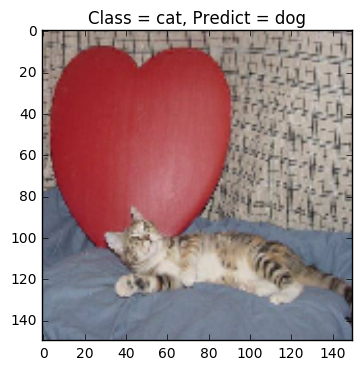

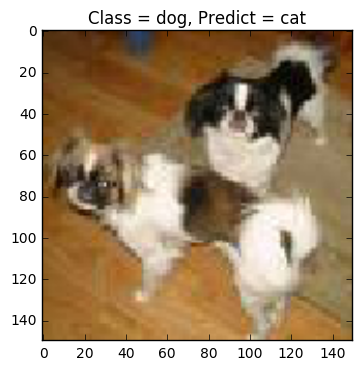

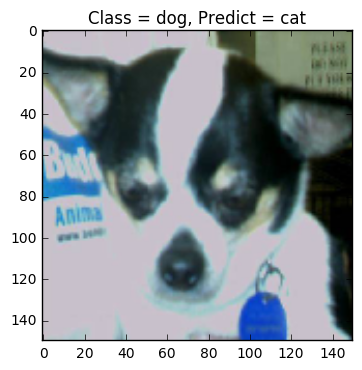

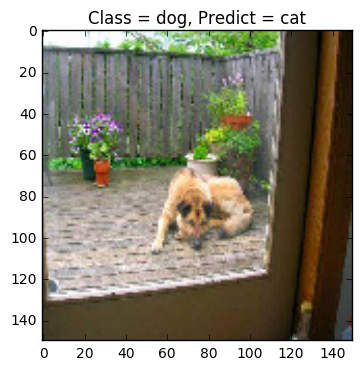

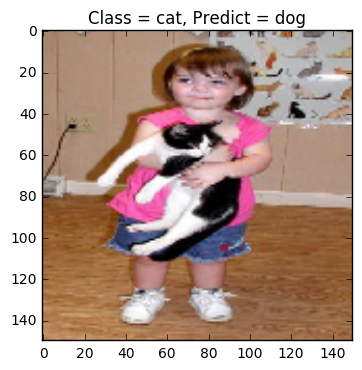

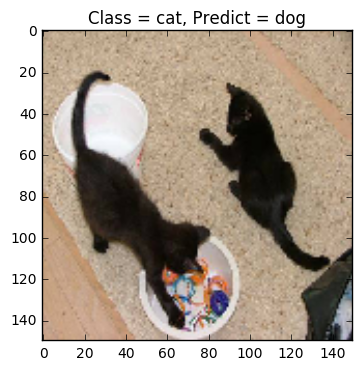

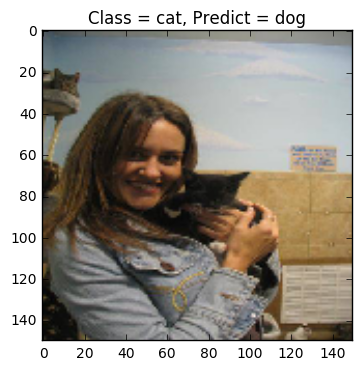

In [8]:
'''Show incorrect predicted valdation samples.'''
incorrect_samples_to_show=7
validation_generator.shuffle=False
def predict_validation():
    '''Makes predicition on the validation set'''
    X_test, y_test = next(validation_generator)
    predictions = tf_model.predict_classes(X_test, batch_size=32, verbose=0)
    return X_test,y_test,predictions

def show_incorrect_sample(X, y, prediction=-1): 
    ''' This function checks if the predicted label is different from the actual label.'''
    if prediction >= 0:
        if prediction!=int(y):
            im = X
            plt.imshow(im)
            plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
            plt.axis('on')
            plt.show()
            return True
            
# call show_incorrect_sample on images in the validation set.
incorr_images=0
while incorr_images<incorrect_samples_to_show: # will show only incorrect_samples_to_show images which are incorrect
    X_test,y_test,predictions=predict_validation()
    for i in range(32):
        incorr=show_incorrect_sample(X_test[i, :, :, :], y_test[i], prediction=predictions[i, 0])
        if incorr==True:
            incorr_images+=1
        if incorr_images==incorrect_samples_to_show:
            break

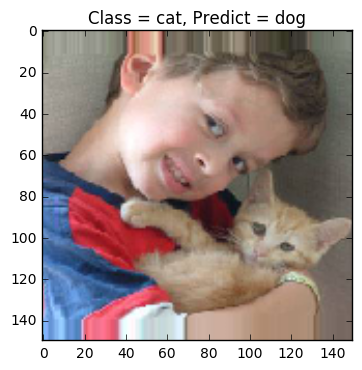

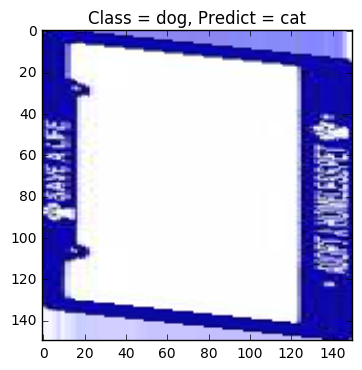

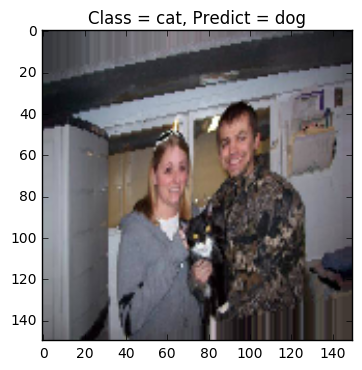

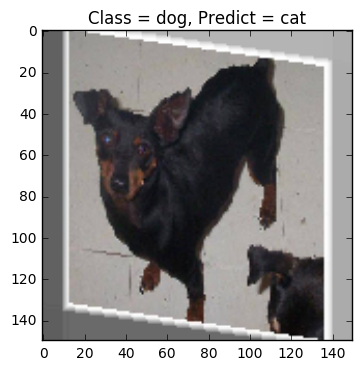

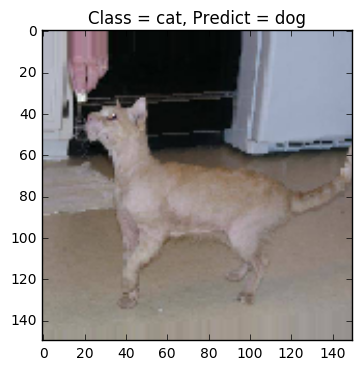

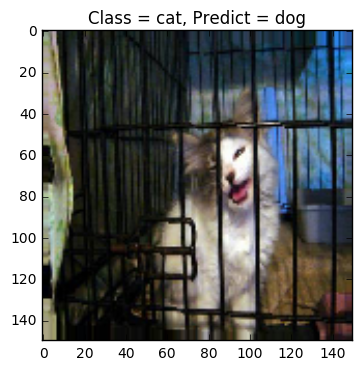

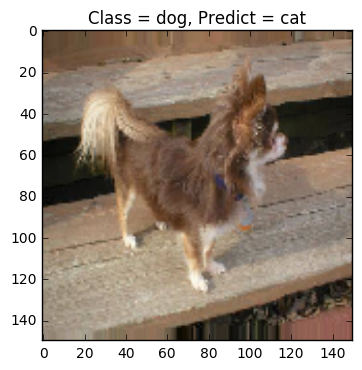

In [9]:
'''Show incorrect predicted train samples.'''
incorrect_samples_to_show=7
train_generator.shuffle=False

def predict_train():
    '''Makes predicition on the train set'''
    X_test, y_test = next(train_generator)
    predictions = tf_model.predict_classes(X_test, batch_size=32, verbose=0)
    return X_test,y_test,predictions

def show_incorrect_sample(X, y, prediction=-1): 
    ''' This function checks if the predicted label is different from the actual label.'''
    if prediction >= 0:
        if prediction!=int(y):
            im = X
            plt.imshow(im)
            plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
            plt.axis('on')
            plt.show()
            return True
            
# call show_incorrect_sample on images in the validation set.
incorr_images=0
while incorr_images<incorrect_samples_to_show: # will show only incorrect_samples_to_show images which are incorrect
    X_train,y_train,predictions=predict_train()
    for i in range(32):
        incorr=show_incorrect_sample(X_train[i, :, :, :], y_train[i], prediction=predictions[i, 0])
        if incorr==True:
            incorr_images+=1
        if incorr_images==incorrect_samples_to_show:
            break

In [ ]:
### EXTRA:
'''I. Other things with which one could achieve greater validation accuracy:

1. Having data augmentation being more aggressive such as vertical flip,
    width_shift, height_shift, random channel_shift, zca_whitening etc.
2. Having Dropout also being aggressive.
3. Using L1 or L2 regularization 

Can also use batch normalization to accelerate learning and avoid the 
problem of internal covariate shift.
'''

In [19]:
# Making dropout more aggressive:
tf_model.layers[-1].layers[2].p=0.65
nb_epoch=1
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
hist_little_convet = tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,
        verbose=2)

Epoch 1/1
1317s - loss: 0.0406 - acc: 0.9851 - val_loss: 0.1168 - val_acc: 0.9620


In [20]:
# Adding L2 regularization to the last two dense layers
import keras
tf_model.layers[-1].layers[2].p=0.5
# L2 Regularization with 0.01 on the dense layers
tf_model.layers[-1].layers[1].W_regularizer=keras.regularizers.l2(0.01)
tf_model.layers[-1].layers[3].W_regularizer=keras.regularizers.l2(0.01)
nb_epoch=1
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
hist_little_convet = tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,
        verbose=2)

Epoch 1/1
1317s - loss: 0.0373 - acc: 0.9858 - val_loss: 0.0975 - val_acc: 0.9645


In [21]:
# Adding L1 regularization to the last two dense layers
import keras
# L1 Regularization with 0.01 on the dense layers
tf_model.layers[-1].layers[1].W_regularizer=keras.regularizers.l1(0.01)
tf_model.layers[-1].layers[3].W_regularizer=keras.regularizers.l1(0.01)
nb_epoch=1
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
hist_little_convet = tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,
        verbose=2)

Epoch 1/1
1317s - loss: 0.0327 - acc: 0.9877 - val_loss: 0.1076 - val_acc: 0.9665


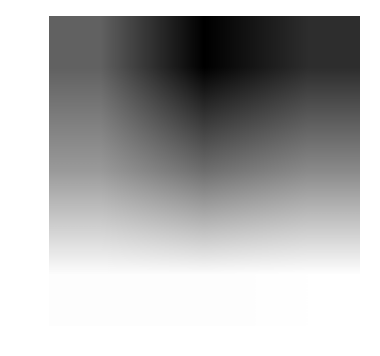

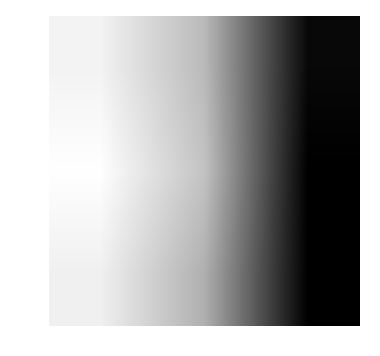

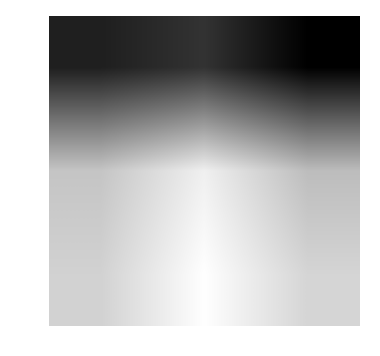

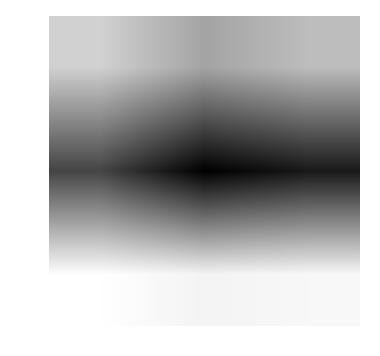

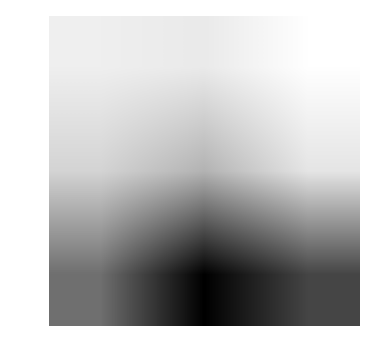

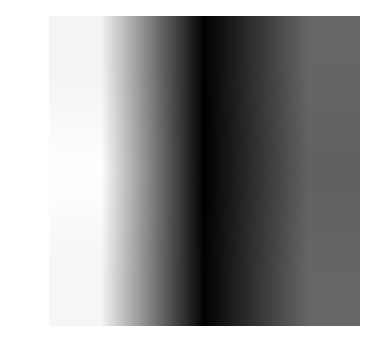

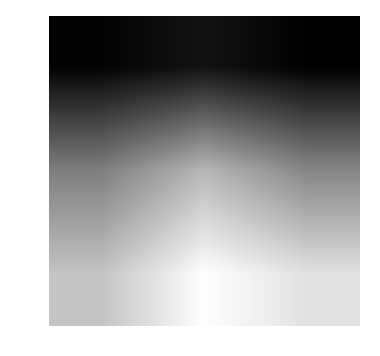

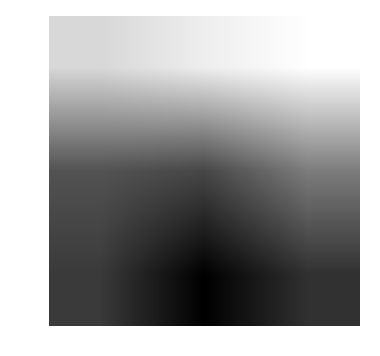

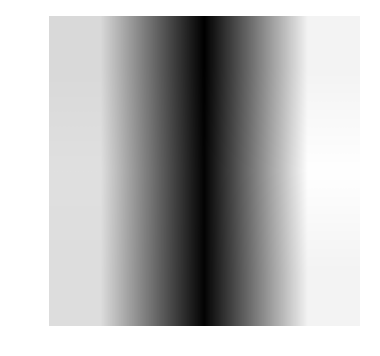

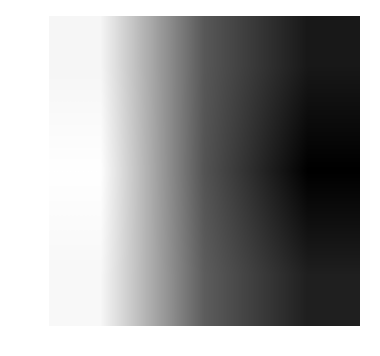

In [22]:
'''II. Looking at what the filters are learning? 
       by visualizing the some weights in 1st Conv. Layer.'''
wts=tf_model.layers[1].get_weights()
filters_wts=wts[0][0]
for ind in range(10):
    filter_wt=filters_wts[:,:,ind]
    plt.axis("off")
    plt.imshow(filter_wt, cmap="Greys_r")
    plt.show()
# Result: Somewhat gabor like filters